## ***Libraries***

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_classif

## ***Data***

In [62]:
data = pd.read_excel('dataset_sleep_disorder.xlsx')

In [ ]:
data

,Person ID,Gender,Age,Job,Sleep Duration,Quality of Sleep,Physical Activity,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16843,16844,Female,51,Engineer,8.5,9,30,3,Normal,125/80,65,5000,NaN
16844,16845,Female,51,Engineer,8.5,9,30,3,Normal,125/80,65,5000,NaN
16845,16846,Female,51,Nurse,7.1,7,55,6,Normal Weight,125/82,72,6000,NaN
16846,16847,Female,51,Nurse,6.0,6,90,8,Overweight,140/95,75,10000,Sleep Apnea


## ***Summary Statistics***

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16848 entries, 0 to 16847
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Person ID          16848 non-null  int64  
 1   Gender             16848 non-null  object 
 2   Age                16848 non-null  int64  
 3   Job                16848 non-null  object 
 4   Sleep Duration     16848 non-null  float64
 5   Quality of Sleep   16848 non-null  int64  
 6   Physical Activity  16848 non-null  int64  
 7   Stress Level       16848 non-null  int64  
 8   BMI Category       16848 non-null  object 
 9   Blood Pressure     16848 non-null  object 
 10  Heart Rate         16848 non-null  int64  
 11  Daily Steps        16848 non-null  int64  
 12  Sleep Disorder     7291 non-null   object 
dtypes: float64(1), int64(7), object(5)
memory usage: 1.7+ MB


In [ ]:
data.isna().sum()

Person ID               0
Gender                  0
Age                     0
Job                     0
Sleep Duration          0
Quality of Sleep        0
Physical Activity       0
Stress Level            0
BMI Category            0
Blood Pressure          0
Heart Rate              0
Daily Steps             0
Sleep Disorder       9557
dtype: int64

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(data)
print(f"\n{colored('Numerical Columns:','blue', attrs=['reverse'])} {num_cols}\n\n\n{colored('Categorical Columns:','magenta', attrs=['reverse'])} {cat_cols}\n\n\n"
        f"{colored('Cardinal Columns:','cyan', attrs=['reverse'])}{cat_but_car}\n")

Observations: 16848
Variables: 13
cat_cols: 6
num_cols: 6
cat_but_car: 1
num_but_cat: 2

Numerical Columns: ['Person ID', 'Age', 'Sleep Duration', 'Physical Activity', 'Heart Rate', 'Daily Steps']


Categorical Columns: ['Gender', 'Job', 'BMI Category', 'Sleep Disorder', 'Quality of Sleep', 'Stress Level']


Cardinal Columns:['Blood Pressure']



In [ ]:
data.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity,Stress Level,Heart Rate,Daily Steps
count,16848.000000,16848.000000,16848.000000,16848.000000,16848.000000,16848.000000,16848.000000,16848.000000
mean,8424.500000,41.990088,7.082449,7.208511,59.118115,5.530389,70.452576,6855.733618
std,4863.743003,9.135634,0.829603,1.234448,21.461805,1.841116,4.391116,1730.370858
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,4212.750000,33.000000,6.300000,6.000000,45.000000,4.000000,68.000000,5200.000000
50%,8424.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,12636.250000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,16848.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


In [ ]:
def cat_summary(dataframe, col_name, plot=False):
    display(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": round(100 * dataframe[col_name].value_counts() / len(dataframe),3)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [ ]:
for col in cat_cols:
    cat_summary(data, col)

,Gender,Ratio
Gender,,
Male,8431,50.042
Female,8417,49.958


,Job,Ratio
Job,,
Doctor,3839,22.786
Nurse,3791,22.501
Engineer,2601,15.438
Teacher,1792,10.636
Lawyer,1763,10.464
Accountant,1232,7.312
Salesperson,1222,7.253
Scientist,216,1.282
Software Engineer,206,1.223


,BMI Category,Ratio
BMI Category,,
Normal,8419,49.970
Overweight,6890,40.895
Normal Weight,979,5.811
Obese,560,3.324


,Sleep Disorder,Ratio
Sleep Disorder,,
Sleep Apnea,3952,23.457
Insomnia,3339,19.818


,Quality of Sleep,Ratio
Quality of Sleep,,
6,5171,30.692
8,3872,22.982
7,3862,22.923
9,3254,19.314
5,371,2.202
4,318,1.887


,Stress Level,Ratio
Stress Level,,
8,3966,23.540
3,3270,19.409
4,2762,16.394
5,2495,14.809
6,2370,14.067
7,1985,11.782


## ***Correlation***

In [63]:
data['Sleep Disorder'].fillna('No disorder',inplace=True)

Point Biserial Correlation with Target Variable (Numerical Predictors):

Chi-square Statistics and P-values with Target Variable (Categorical Predictors):
Job: Chi-square = 19621.130579390545, P-value = 0.0
Quality of Sleep: Chi-square = 6560.7899154565985, P-value = 0.0
BMI Category: Chi-square = 10999.936224095794, P-value = 0.0
Gender: Chi-square = 2976.4940704269857, P-value = 0.0
Stress Level: Chi-square = 11365.33028329163, P-value = 0.0


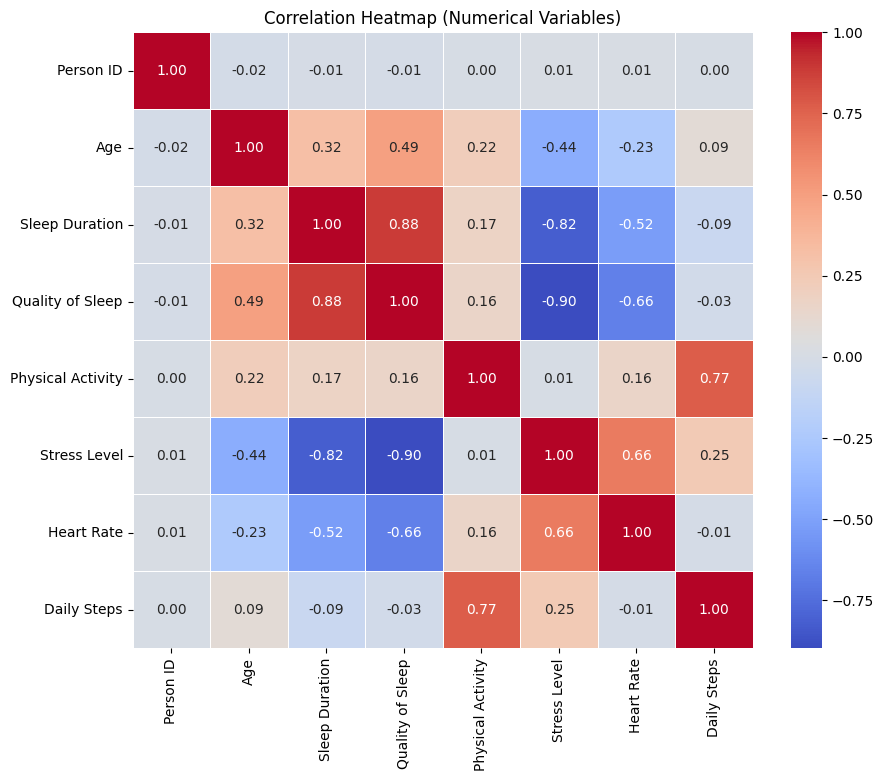

In [ ]:
numerical_predictors = ['Age','Sleep Duration','Physical Activity','Heart Rate','Daily Steps']
categorical_predictors = ['Job','Quality of Sleep','BMI Category','Gender','Stress Level']
chi2_stats = {}
p_values = {}
for column in categorical_predictors:
    contingency_table = pd.crosstab(data[column], data['Sleep Disorder'])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    chi2_stats[column] = chi2
    p_values[column] = p

# Display the point biserial correlations for numerical predictors
print("Point Biserial Correlation with Target Variable (Numerical Predictors):")
for predictor, correlation in point_biserial_correlation.items():
    print(f"{predictor}: {correlation}")

print("\nChi-square Statistics and P-values with Target Variable (Categorical Predictors):")
for predictor in categorical_predictors:
    print(f"{predictor}: Chi-square = {chi2_stats[predictor]}, P-value = {p_values[predictor]}")

numerical_data = data.select_dtypes(include=np.number)
correlation_matrix = numerical_data.corr()

# Create a heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Numerical Variables)')
plt.show()

In [ ]:
point_biserial_corr, _ = stats.pointbiserialr(data['Sleep Duration'], data['Quality of Sleep'])
print("Point-Biserial Correlation Coefficient:", point_biserial_corr)

# Spearman's Rank Correlation
spearman_corr, _ = stats.spearmanr(data['Sleep Duration'], data['Quality of Sleep'])
print("Spearman's Rank Correlation Coefficient:", spearman_corr)

Point-Biserial Correlation Coefficient: 0.881830330682979
Spearman's Rank Correlation Coefficient: 0.8939760007711993


In [ ]:
map = []
for r in range(len(data)):
  if (data['Sleep Duration'][r],data['Quality of Sleep'][r]) not in map:
    map.append((data['Sleep Duration'][r],data['Quality of Sleep'][r]))
map.sort()
map

[(5.8, 4),
 (5.9, 4),
 (5.9, 6),
 (6.0, 6),
 (6.1, 6),
 (6.2, 6),
 (6.3, 6),
 (6.4, 5),
 (6.4, 6),
 (6.5, 5),
 (6.5, 6),
 (6.5, 7),
 (6.6, 5),
 (6.6, 7),
 (6.7, 7),
 (6.8, 6),
 (6.8, 7),
 (6.9, 6),
 (6.9, 7),
 (7.1, 7),
 (7.1, 8),
 (7.2, 8),
 (7.3, 7),
 (7.3, 8),
 (7.4, 7),
 (7.4, 8),
 (7.5, 8),
 (7.6, 7),
 (7.6, 8),
 (7.7, 7),
 (7.7, 8),
 (7.8, 7),
 (7.8, 8),
 (7.9, 7),
 (7.9, 8),
 (8.0, 9),
 (8.1, 9),
 (8.2, 9),
 (8.3, 9),
 (8.4, 9),
 (8.5, 9)]

## ***Data Cleaning***

In [64]:
data.drop(columns = ['Person ID','Quality of Sleep'],axis=1,inplace=True)

In [65]:
data['BMI Category'].replace('Normal Weight','Normal',inplace=True)

## ***Data Preprocessing***

### **Feature Engineering**

In [42]:
# Categorization Functions

# Age Categorizing Function
def categorize_age(df, age_column, bins, labels):
  if age_column not in df.columns:
        raise ValueError(f"The column '{age_column}' does not exist in the DataFrame.")
  df['age_category'] = pd.cut(df[age_column], bins=bins, labels=labels,right=False, include_lowest=True)

  return df

# Blood Pressure Categorizing Function
def categorize_blood_pressure(df, sys_column, dia_column):
  conditions = [
        (df[sys_column] < 120) & (df[dia_column] < 80),
        (df[sys_column] >= 120) & (df[sys_column] < 130) & (df[dia_column] < 80),
        ((df[sys_column] >= 130) & (df[sys_column] < 140)) | ((df[dia_column] >= 80) & (df[dia_column] < 89)),
        (df[sys_column] >= 140) | (df[dia_column] >= 90),
        (df[sys_column] > 180) | (df[dia_column] > 120)
    ]

  categories = [
        'Normal',
        'Elevated',
        'High Blood Pressure (Hypertension) Stage 1',
        'High Blood Pressure (Hypertension) Stage 2',
        'Hypertensive Crisis'
    ]

  df['BP_Category'] = np.select(conditions, categories, default='Unknown')

  return df

In [66]:
bins = [18, 30, 40, 50, 101]
labels = ['18-29', '30-39', '40-49', '50-100']
data = categorize_age(data, 'Age', bins, labels)
data.drop('Age',axis=1,inplace=True)

In [67]:
data[['Systolic', 'Diastolic']] = data['Blood Pressure'].str.split('/', expand=True)

data['Systolic'] = data['Systolic'].astype(int)
data['Diastolic'] = data['Diastolic'].astype(int)

data = categorize_blood_pressure(data, 'Systolic', 'Diastolic')
data.drop(columns=['Blood Pressure','Systolic','Diastolic'],axis=1,inplace= True)

### **Encoding** (before feature extraction)

In [68]:
categorical_columns = ['Gender','BMI Category','BP_Category','age_category','Job']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

data_encoded = pd.concat([data, one_hot_df], axis=1)
data_encoded = data_encoded.drop(categorical_columns, axis=1)

In [69]:
le = LabelEncoder()
le.fit(data['Sleep Disorder'])
encoded_labels = le.transform(data['Sleep Disorder'])
data_encoded['Target'] = encoded_labels
data_encoded.drop('Sleep Disorder',axis=1,inplace = True)

In [70]:
# Get unique encoded labels
unique_encoded_labels = data_encoded['Target'].unique()

# Map encoded labels to their original values
original_labels = le.inverse_transform(unique_encoded_labels)

# Print original labels along with their encoded values
for encoded_label, original_label in zip(unique_encoded_labels, original_labels):
    print(f"Encoded Label: {encoded_label}, Original Label: {original_label}")


Encoded Label: 1, Original Label: No disorder
Encoded Label: 2, Original Label: Sleep Apnea
Encoded Label: 0, Original Label: Insomnia


### **Scaling**

In [71]:
scaler = MinMaxScaler()
cols = ['Sleep Duration','Physical Activity','Heart Rate','Daily Steps','Stress Level']
for c in cols:
  column_data = data_encoded[c].values.reshape(-1, 1)
  data_encoded[c] = scaler.fit_transform(column_data)

### **Data Splitting** (before feature extraction)

In [72]:
X = data_encoded.drop('Target', axis=1)
y = data_encoded['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## ***Feature Extraction***

In [79]:
# Select top k features based on mutual information
k = 3  # Number of features to select
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X_train, y_train)

# Transform the dataset to include only the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_feature_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_feature_indices]  # Assuming X_train is a DataFrame
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['Sleep Duration', 'Physical Activity', 'Daily Steps'], dtype='object')


### Removing unwanted features after feature extraction

In [74]:
data.drop('Job',axis=1,inplace=True)

### **Encoding** (after feature extraction)

In [75]:
categorical_columns = ['Gender','BMI Category','BP_Category','age_category']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

data_encoded = pd.concat([data, one_hot_df], axis=1)
data_encoded = data_encoded.drop(categorical_columns, axis=1)

In [76]:
le = LabelEncoder()
le.fit(data['Sleep Disorder'])
encoded_labels = le.transform(data['Sleep Disorder'])
data_encoded['Target'] = encoded_labels
data_encoded.drop('Sleep Disorder',axis=1,inplace = True)

## ***Model Training***

### **Data Splitting** (after feature extraction)

In [77]:
X = data_encoded.drop('Target', axis=1)
y = data_encoded['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### **Models**

In [ ]:
classifiers = {
    'KNN':KNeighborsClassifier(3),
    'SVC':SVC(gamma=2, C=1, random_state=42),
    'Decision Tree':DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest':RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    'AdaBoost':AdaBoostClassifier(algorithm="SAMME", random_state=42),
    'Gaussian Naive Bayes':GaussianNB(),
    'Gradient Boosting':GradientBoostingClassifier(n_estimators=300, learning_rate=0.35, max_depth=11),
    'XGBoost':xgb.XGBClassifier(n_estimators=250, learning_rate=0.47, max_depth=9)
}

In [ ]:
for name,clf in classifiers.items():
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(f"{name} classification report:\n{classification_report(y_test,y_pred)}\n------------------------")

KNN classification report:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      1040
           1       0.88      0.90      0.89      3197
           2       0.81      0.73      0.76      1323

    accuracy                           0.83      5560
   macro avg       0.80      0.80      0.80      5560
weighted avg       0.83      0.83      0.83      5560

------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1040
           1       0.57      1.00      0.73      3197
           2       0.00      0.00      0.00      1323

    accuracy                           0.57      5560
   macro avg       0.19      0.33      0.24      5560
weighted avg       0.33      0.57      0.42      5560

------------------------
Decision Tree classification report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1040
           1       0.95      0.96      0.95      3197
           2       0.93      0.86      0.89      1323

    accuracy                           0.92      5560
   macro avg       0.90      0.90      0.90      5560
weighted avg       0.92      0.92      0.92      5560

------------------------
Random Forest classification report:
              precision    recall  f1-score   support

           0       0.88      0.8

In [ ]:
model = SVC(gamma=2, C=1, random_state=42)
model.fit(X_train,y_train)

In [ ]:
import joblib
joblib.dump(model, 'sleepdisordermodel.pkl')

In [ ]:
joblib.dump(encoder, 'gender-BMI-BP-ageEncoder.pkl')